##Libraries

In [ ]:
!pip install segmentation-models-3D

In [ ]:
###Libraries and imports
import nibabel as nib
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, gaussian_filter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Conv3DTranspose, Cropping3D, ZeroPadding3D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from segmentation_models_3D.losses import DiceLoss
from tensorflow.keras.losses import CategoricalCrossentropy
from segmentation_models_3D.metrics import IOUScore, FScore
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
import cv2
import random
from sklearn.model_selection import train_test_split

##Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to the dataset in Google Drive
base_path = '/content/drive/My Drive/BraTS2021/'

In [ ]:
# Set mixed precision policy to reduce memory usage
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# Define a function to load all file paths for each modality
def load_file_paths(base_path):
    # Define empty lists for storing paths of each modality
    flair_files = []
    t1_files = []
    t1ce_files = []
    t2_files = []
    seg_files = []

    # Traverse through all folders and subfolders in the base path
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('_flair.nii') or file.endswith('_flair.nii.gz'):
                flair_files.append(os.path.join(root, file))
            elif file.endswith('_t1.nii') or file.endswith('_t1.nii.gz'):
                t1_files.append(os.path.join(root, file))
            elif file.endswith('_t1ce.nii') or file.endswith('_t1ce.nii.gz'):
                t1ce_files.append(os.path.join(root, file))
            elif file.endswith('_t2.nii') or file.endswith('_t2.nii.gz'):
                t2_files.append(os.path.join(root, file))
            elif file.endswith('_seg.nii') or file.endswith('_seg.nii.gz'):
                seg_files.append(os.path.join(root, file))

    return flair_files, t1_files, t1ce_files, t2_files, seg_files

# Load file paths for each modality
flair_files, t1_files, t1ce_files, t2_files, seg_files = load_file_paths(base_path)

# Print out the number of files found for each modality
print(f"Number of FLAIR files: {len(flair_files)}")
print(f"Number of T1 files: {len(t1_files)}")
print(f"Number of T1CE files: {len(t1ce_files)}")
print(f"Number of T2 files: {len(t2_files)}")
print(f"Number of Segmentation files: {len(seg_files)}")


Number of FLAIR files: 1253
Number of T1 files: 1253
Number of T1CE files: 1253
Number of T2 files: 1253
Number of Segmentation files: 1253


 - File paths are legit, let's continue

In [ ]:
# Check if the number of files is consistent across all modalities
assert len(flair_files) == len(t1_files) == len(t1ce_files) == len(t2_files) == len(seg_files), "Mismatch in the number of files across modalities."
print("All modalities have a consistent number of files.")

All modalities have a consistent number of files.


In [ ]:
import nibabel as nib

# Function to load and display the shape of a sample file from each modality
def load_and_verify_sample(flair_file, t1_file, t1ce_file, t2_file, seg_file):
    try:
        # Load FLAIR
        flair_img = nib.load(flair_file)
        print(f"FLAIR shape: {flair_img.shape}")

        # Load T1
        t1_img = nib.load(t1_file)
        print(f"T1 shape: {t1_img.shape}")

        # Load T1CE
        t1ce_img = nib.load(t1ce_file)
        print(f"T1CE shape: {t1ce_img.shape}")

        # Load T2
        t2_img = nib.load(t2_file)
        print(f"T2 shape: {t2_img.shape}")

        # Load Segmentation
        seg_img = nib.load(seg_file)
        print(f"Segmentation shape: {seg_img.shape}")

    except Exception as e:
        print(f"Error loading files: {e}")

# Load and verify a sample from the first patient
load_and_verify_sample(flair_files[0], t1_files[0], t1ce_files[0], t2_files[0], seg_files[0])


FLAIR shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1CE shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Segmentation shape: (240, 240, 155)


 - Finally some good good beautiful news.

In [ ]:
# Split dataset into training and validation sets
indices = list(range(len(flair_files)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(val_indices)}")

Number of training samples: 1002
Number of validation samples: 251


**OPTIMIZED CHANGES HERE**

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, indices, batch_size=2, augment=False, useful_threshold=0.03):
        self.indices = indices
        self.batch_size = batch_size
        self.augment = augment
        self.useful_threshold = useful_threshold  # Threshold for useful volume

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for i in batch_indices:
            # Load data for the patient
            flair = nib.load(flair_files[i]).get_fdata()
            t1 = nib.load(t1_files[i]).get_fdata()
            t1ce = nib.load(t1ce_files[i]).get_fdata()
            t2 = nib.load(t2_files[i]).get_fdata()
            seg = nib.load(seg_files[i]).get_fdata()

            # Check for useful volume in each modality
            if (
                self._useful_volume(flair) < self.useful_threshold or
                self._useful_volume(t1) < self.useful_threshold or
                self._useful_volume(t1ce) < self.useful_threshold or
                self._useful_volume(t2) < self.useful_threshold
            ):
                print(f"[INFO] Skipping patient {i} due to insufficient useful volume.")
                continue

            # Stack modalities as channels
            input_image = np.stack([flair, t1, t1ce, t2], axis=-1)

            # Pad the depth dimension from 155 to 160
            pad_diff = 160 - input_image.shape[2]
            if pad_diff > 0:
                input_image = np.pad(input_image, ((0, 0), (0, 0), (0, pad_diff), (0, 0)), mode='constant')
                seg = np.pad(seg, ((0, 0), (0, 0), (0, pad_diff)), mode='constant')

            # Normalize each modality independently
            input_image[..., 0] = self._normalize(input_image[..., 0])  # FLAIR
            input_image[..., 1] = self._normalize(input_image[..., 1])  # T1
            input_image[..., 2] = self._normalize(input_image[..., 2])  # T1CE
            input_image[..., 3] = self._normalize(input_image[..., 3])  # T2

            # Convert segmentation mask to categorical
            seg = to_categorical(seg, num_classes=5)

            # Data augmentation (if enabled)
            if self.augment:
                if random.random() > 0.5:
                    angle = random.uniform(-10, 10)
                    input_image = rotate(input_image, angle, axes=(0, 1), reshape=False, mode='nearest')
                    seg = rotate(seg, angle, axes=(0, 1), reshape=False, mode='nearest')

            X.append(input_image)
            y.append(seg)

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def _normalize(self, volume):
        """Normalize a 3D volume to the range [0, 1]."""
        return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    def _useful_volume(self, volume):
        """Calculate the proportion of useful volume (non-zero voxels)."""
        return 1 - (np.sum(volume == 0) / volume.size)


**CHanged Batch from 1 to 4**

In [ ]:
# Create data generators
# Create data generators
# 3% threshold for useful pixels to include instance
train_generator = DataGenerator(indices=train_indices, batch_size=4, augment=True, useful_threshold=0.03)
val_generator = DataGenerator(indices=val_indices, batch_size=4, augment=False, useful_threshold=0.03)

In [ ]:
# Training instances
train_total_instances = len(train_generator.indices)
print(f"Total number of training instances: {train_total_instances}")

# Validation instances
val_total_instances = len(val_generator.indices)
print(f"Total number of validation instances: {val_total_instances}")

Total number of training instances: 1002
Total number of validation instances: 251


In [ ]:
class CheckpointedLayer(keras.layers.Layer):
    def call(self, inputs, training=False):
        if training:
            return tf.recompute_grad(lambda: super().call(inputs))
        else:
            return super().call(inputs)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_generator, output_signature=(
    tf.TensorSpec(shape=(None, 240, 240, 160, 4), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 240, 240, 160, 5), dtype=tf.float32))
)

val_dataset = tf.data.Dataset.from_generator(lambda: val_generator, output_signature=(
    tf.TensorSpec(shape=(None, 240, 240, 160, 4), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 240, 240, 160, 5), dtype=tf.float32))
)

# Prefetch for efficiency
train_dataset = train_dataset.batch(1).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(1).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def enhanced_unet_model(input_shape):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Expansive Path
    up5 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    outputs = Conv3D(5, (1, 1, 1), activation='softmax')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# Input shape with even depth to prevent mismatches
input_shape = (240, 240, 160, 4)  # Note: depth is now 160 (even number, power of 2)
model = enhanced_unet_model(input_shape)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 240, 240, 160,  │              0 │ -                      │
│ (InputLayer)              │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_15 (Conv3D)        │ (None, 240, 240, 160,  │          3,488 │ input_layer_1[0][0]    │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 240, 240, 160,  │            128 │ conv3d_15[0][0]        │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_16 (Conv3D)        │ (None, 240, 240, 160,  │         27,680 │ batch_normalization_1… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 240, 240, 160,  │            128 │ conv3d_16[0][0]        │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_3           │ (None, 120, 120, 80,   │              0 │ batch_normalization_1… │
│ (MaxPooling3D)            │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_17 (Conv3D)        │ (None, 120, 120, 80,   │         55,360 │ max_pooling3d_3[0][0]  │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 120, 120, 80,   │            256 │ conv3d_17[0][0]        │
│ (BatchNormalization)      │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_18 (Conv3D)        │ (None, 120, 120, 80,   │        110,656 │ batch_normalization_1… │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 120, 120, 80,   │            256 │ conv3d_18[0][0]        │
│ (BatchNormalization)      │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 60, 60, 40, 64) │              0 │ batch_normalization_1… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 60, 60, 40,     │        221,312 │ max_pooling3d_4[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 60, 60, 40,     │            512 │ conv3d_19[0][0]        │
│ (BatchNormalization)      │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,608,069 (21.39 MB)

 Trainable params: 5,605,253 (21.38 MB)

 Non-trainable params: 2,816 (11.00 KB)

**OPTIMIZED CHANGES HERE**

In [ ]:
dice_loss = DiceLoss()
crossentropy_loss = CategoricalCrossentropy()

In [ ]:
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + crossentropy_loss(y_true, y_pred)

In [ ]:
metrics = [IOUScore(threshold=0.5), FScore(threshold=0.5), 'accuracy']

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-4,
    verbose=1
)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=metrics)

In [ ]:
# Train the model with EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_generator, validation_data=val_generator, epochs=5, verbose=1, callbacks=[reduce_lr])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 12834s 49s/step - accuracy: 0.8506 - f1-score: 0.2044 - iou_score: 0.1607 - loss: 1.9372 - val_accuracy: 0.9900 - val_f1-score: 0.4132 - val_iou_score: 0.4059 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 10084s 39s/step - accuracy: 0.9926 - f1-score: 0.6695 - iou_score: 0.5852 - loss: 0.7194 - val_accuracy: 0.9914 - val_f1-score: 0.6571 - val_iou_score: 0.5775 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 10197s 40s/step - accuracy: 0.9933 - f1-score: 0.7131 - iou_score: 0.6234 - loss: 0.5524 - val_accuracy: 0.9887 - val_f1-score: 0.4670 - val_iou_score: 0.4193 - val_loss: 0.7775 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 10225s 40s/step - accuracy: 0.9941 - f1-score: 0.7353 - iou_score: 0.6439 - loss: 0.4988 - val_accuracy: 0.9940 - val_f1-score: 0.7286 - val_iou_score: 0.6385 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 10678s 

 - TRAIN TO ONLY 4 EPOCHS NEXT TIME

In [ ]:
model.save('Modified_Model_V22.keras')

NameError: name 'model' is not defined

**ADD STEP TO AUTOMATICALLY DOWNLOAD FILE**

In [ ]:
# Post-processing Function
# Function to Apply Post-Processing to Predictions
def post_process_prediction(prediction):
    # Example: Apply morphological closing
    prediction = prediction.argmax(axis=-1)
    for i in range(prediction.shape[2]):
        prediction[:, :, i] = cv2.morphologyEx(prediction[:, :, i].astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    return prediction

**With Post Processing**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


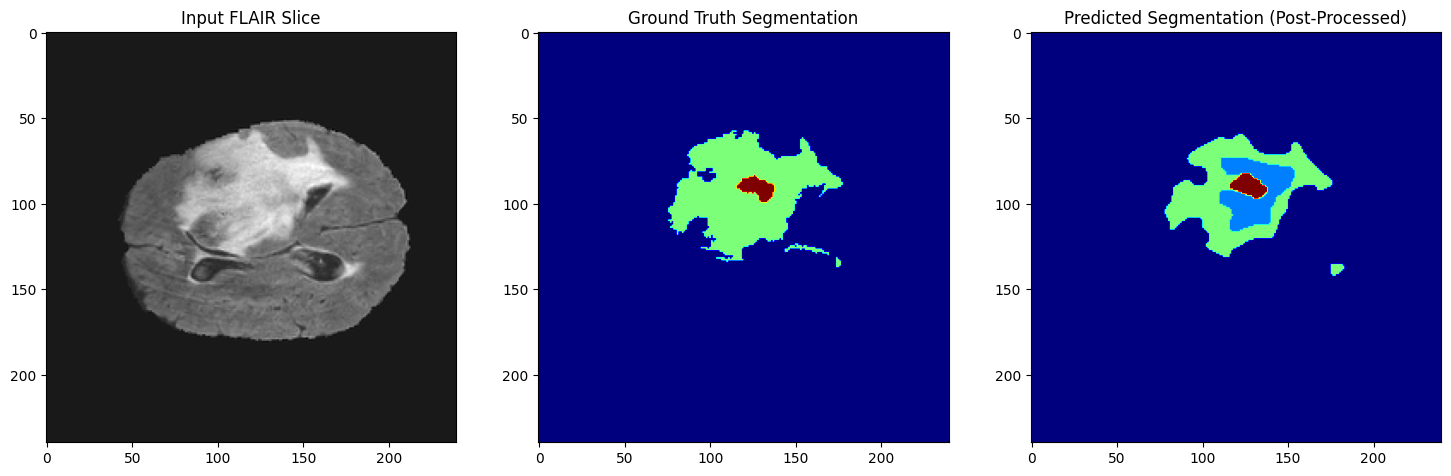

In [ ]:
# Model Evaluation and Visualization
# Function to Visualize Predictions with Post-Processing
def plot_predictions(model, index):
    X, y_true = train_generator[index]  # Load data from the training set for visualization
    y_pred = model.predict(X)[0]

    y_pred_post_processed = post_process_prediction(y_pred)

    # Plotting the original input, ground truth, and predicted segmentation
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(X[0][:, :, X[0].shape[2] // 2, 0], cmap='gray')
    axes[0].set_title('Input FLAIR Slice')
    axes[1].imshow(y_true[0][:, :, X[0].shape[2] // 2].argmax(axis=-1), cmap='jet')
    axes[1].set_title('Ground Truth Segmentation')
    axes[2].imshow(y_pred_post_processed[:, :, X[0].shape[2] // 2], cmap='jet')
    axes[2].set_title('Predicted Segmentation (Post-Processed)')
    plt.show()

# Example usage of the plot_predictions function
plot_predictions(model, index=0)

**Without Post Processing**

In [ ]:
def plot_predictions(model, index):
    X, y_true = train_generator[index]  # Load data from the training set for visualization
    y_pred = model.predict(X)[0]

    # Remove the singleton dimension from X and y_true
    X = np.squeeze(X, axis=0)
    y_true = np.squeeze(y_true, axis=0)

    # Plot the original input, ground truth, and prediction
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Display the middle slice of the FLAIR modality
    axes[0].imshow(X[:, :, X.shape[2] // 2, 0], cmap='gray')
    axes[0].set_title('Input FLAIR (Middle Slice)')

    # Display the middle slice of the ground truth segmentation mask
    axes[1].imshow(np.argmax(y_true[:, :, X.shape[2] // 2], axis=-1), cmap='gray')
    axes[1].set_title('Ground Truth Segmentation (Middle Slice)')

    # Display the middle slice of the predicted segmentation mask
    axes[2].imshow(np.argmax(y_pred[:, :, X.shape[2] // 2], axis=-1), cmap='gray')
    axes[2].set_title('Predicted Segmentation (Middle Slice)')

    plt.show()

# Plot predictions for a sample
plot_predictions(model, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


ValueError: cannot select an axis to squeeze out which has size not equal to one

##Preprocessing

 - Removed some processes because it ruined image quality

##EDA

##Model Definition U-Net

##Combined Loss Function (Dice + Cross-Entropy)

##Data Generator

##Model Training

##Post Processing

##Model Eval/Visualization

 **BraTS Challenge** focuses on analyzing and segmenting gliomas using multi-parametric MRI (mpMRI) data. The dataset includes:

1. **MRI Modalities**:
   - Native T1-weighted (T1)
   - Post-contrast T1-weighted (T1Gd)
   - T2-weighted (T2)
   - T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

2. **File Format**:
   - MRI scans are provided as **NIfTI files (.nii.gz)**.
   - Associated de-identified DICOM files (.dcm) might be released later.

3. **Annotations**:
   - Tumor sub-regions are segmented and labeled as:
     - **GD-enhancing tumor (ET)**: Label 4
     - **Peritumoral edematous/invaded tissue (ED)**: Label 2
     - **Necrotic tumor core (NCR)**: Label 1

4. **Data Preprocessing**:
   - Images are **co-registered** to a common anatomical template.
   - Interpolated to a uniform voxel resolution of **1 mm³**.
   - Skull-stripped.

5. **Clinical Background**:
   - The dataset includes **multi-institutional, routine clinically-acquired mpMRI scans**.
   - All scans are pathologically confirmed and have MGMT promoter methylation status.

This dataset is designed for tasks such as tumor segmentation, classification, or related applications in glioma research. It is pre-processed for consistency and quality and includes detailed ground truth annotations validated by expert neuroradiologists.
